In [5]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

API_KEY = 'NZVUI9K5KV8CLIED'

def get_exchange_rate(from_symbol, to_symbol, file_name):
    url = f"https://www.alphavantage.co/query?function=FX_DAILY&from_symbol={from_symbol}&to_symbol={to_symbol}&outputsize=full&datatype=csv&apikey={API_KEY}"
    response = requests.get(url)

    if response.status_code == 200:
        drive_path = f"../data/raw/{file_name}"
        with open(drive_path, "wb") as file:
            file.write(response.content)
        print(f"Dữ liệu {from_symbol}/{to_symbol} đã được lưu vào {drive_path}")
    else:
        print(f"Lỗi khi lấy dữ liệu {from_symbol}/{to_symbol}: {response.status_code}")
#u = f"https://www.alphavantage.co/query?function=FX_DAILY&from_symbol=EUR&to_symbol=VND&outputsize=full&datatype=csv&apikey=NZVUI9K5KV8CLIED"

get_exchange_rate('EUR', 'VND', "EUR_VND_Exchange_Rate.csv")


Dữ liệu EUR/VND đã được lưu vào ../data/raw/EUR_VND_Exchange_Rate.csv


### **IQR**

In [6]:
df = pd.read_csv("../data/raw/EUR_VND_Exchange_Rate.csv")
df.head()

,timestamp,open,high,low,close
0,2025-04-01,27649.0,27703.0,27622.0,27650.0
1,2025-03-31,27675.0,27675.0,27570.0,27646.0
2,2025-03-28,27588.0,27670.0,27515.0,27658.0
3,2025-03-27,27508.0,27603.0,27505.0,27592.0
4,2025-03-26,27612.0,27618.0,27451.0,27469.0


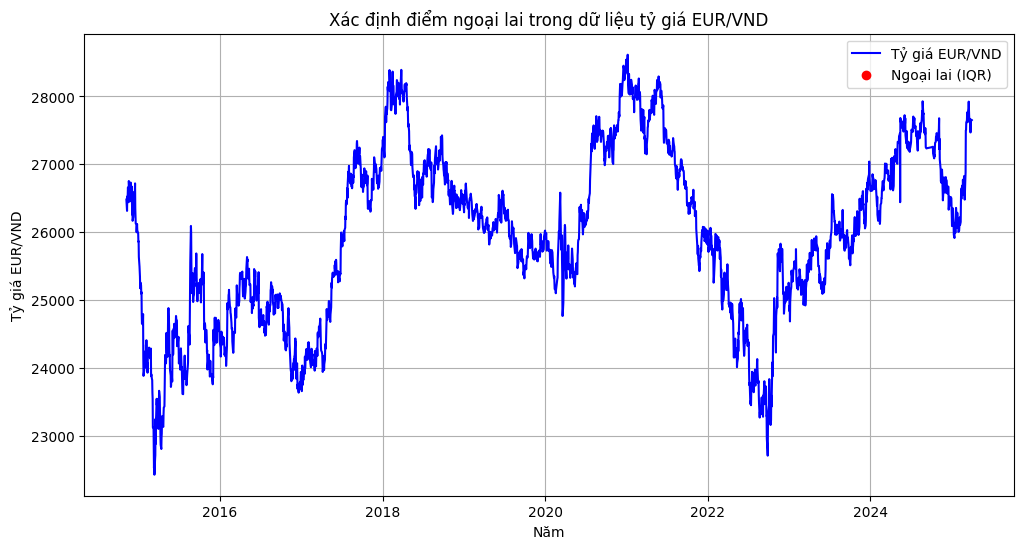

In [7]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index("timestamp", inplace=True)
df.head()
# Lọc cột "Close" (tỷ giá đóng cửa)
prices = df["close"]

# Loại bỏ giá trị 0 nếu có
prices = prices[prices > 0]

# Xác định IQR
Q1 = prices.quantile(0.25)
Q3 = prices.quantile(0.75)
IQR = Q3 - Q1

# Xác định ngưỡng ngoại lai
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Xác định điểm ngoại lai
outliers = (prices < lower_bound) | (prices > upper_bound)

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(prices.index, prices, label="Tỷ giá EUR/VND", color="blue")
plt.scatter(prices.index[outliers], prices[outliers], color="red", label="Ngoại lai (IQR)")
plt.xlabel("Năm")
plt.ylabel("Tỷ giá EUR/VND")
plt.title("Xác định điểm ngoại lai trong dữ liệu tỷ giá EUR/VND")
plt.legend()
plt.grid()
plt.show()


In [8]:
df.head()

,open,high,low,close
timestamp,,,,
2025-04-01,27649.0,27703.0,27622.0,27650.0
2025-03-31,27675.0,27675.0,27570.0,27646.0
2025-03-28,27588.0,27670.0,27515.0,27658.0
2025-03-27,27508.0,27603.0,27505.0,27592.0
2025-03-26,27612.0,27618.0,27451.0,27469.0


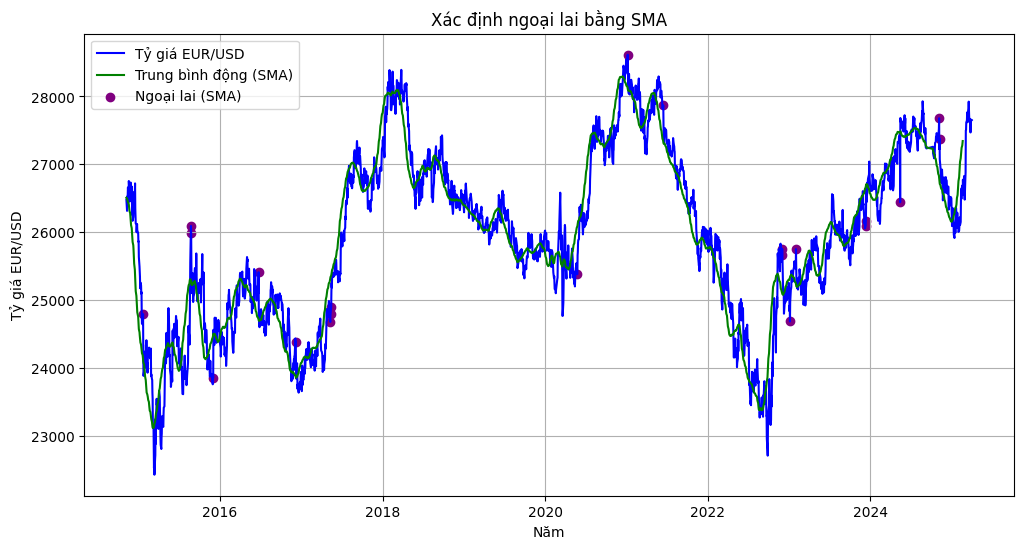

In [9]:
window = 30 # Ví dụ: lấy trung bình trong 30 ngày
sma = prices.rolling(window=window).mean()
std_dev = prices.rolling(window=window).std()

# Xác định ngoại lai dựa trên SMA ± 3*std_dev
sma_outliers = (prices > sma + 3 * std_dev) | (prices < sma - 3 * std_dev)

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(prices.index, prices, label="Tỷ giá EUR/USD", color="blue")
plt.plot(prices.index, sma, label="Trung bình động (SMA)", color="green")
plt.scatter(prices.index[sma_outliers], prices[sma_outliers], color="purple", label="Ngoại lai (SMA)", marker="o")
plt.xlabel("Năm")
plt.ylabel("Tỷ giá EUR/USD")
plt.title("Xác định ngoại lai bằng SMA")
plt.legend()
plt.grid()
plt.show()


In [10]:
num_outliers = sma_outliers.sum()
print(f"Số lượng điểm ngoại lai: {num_outliers}")


Số lượng điểm ngoại lai: 21


In [11]:
outlier_dates = prices.index[sma_outliers]
print(outlier_dates)


DatetimeIndex(['2024-11-07', '2024-11-05', '2024-05-14', '2023-12-12',
               '2023-12-11', '2023-02-01', '2023-01-05', '2022-12-02',
               '2022-12-01', '2021-06-15', '2021-01-06', '2020-05-25',
               '2017-05-15', '2017-05-12', '2017-05-11', '2016-12-07',
               '2016-06-23', '2015-12-02', '2015-08-25', '2015-08-24',
               '2015-01-21'],
              dtype='datetime64[ns]', name='timestamp', freq=None)


# **EURVND**

In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1️⃣ Lấy dữ liệu tỷ giá JPY/VND từ Yahoo Finance
data = yf.download("EURVND=X", start="2006-01-01", interval="1d")["Close"]
data = data.dropna()  # Loại bỏ giá trị NaN

# 2️⃣ Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(data).reshape(-1, 1))

# 3️⃣ Chuẩn bị dữ liệu cho mô hình LSTM
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60  # Sử dụng 60 ngày trước đó để dự đoán ngày tiếp theo
X, Y = create_dataset(data_scaled, time_step)

# Chia tập dữ liệu thành train/test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Reshape lại dữ liệu đầu vào (LSTM yêu cầu 3D)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 4️⃣ Xây dựng mô hình LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# 5️⃣ Huấn luyện mô hình
model.fit(X_train, Y_train, batch_size=16, epochs=50, verbose=1)

# 6️⃣ Dự đoán
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Chuyển giá trị về dạng ban đầu
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train_actual = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1))

ModuleNotFoundError: No module named 'yfinance'

In [ ]:
# Điều chỉnh index để khớp với số lượng phần tử của Y_train_actual và Y_test_actual
train_index = data.index[time_step:train_size + time_step]
test_index = data.index[train_size + time_step + 1:]

plt.figure(figsize=(12, 6))
plt.plot(train_index, Y_train_actual, label="Thực tế (Train)", color="blue")
plt.plot(test_index, Y_test_actual, label="Thực tế (Test)", color="red")
plt.plot(test_index, test_predict, label="Dự đoán (Test)", color="green")

plt.xlabel("Năm")
plt.ylabel("Tỷ giá USD/VND")
plt.title("Dự đoán tỷ giá USD/VND bằng LSTM")
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Tính MAE
mae_train = mean_absolute_error(Y_train_actual, train_predict)
mae_test = mean_absolute_error(Y_test_actual, test_predict)

# Tính RMSE
rmse_train = np.sqrt(mean_squared_error(Y_train_actual, train_predict))
rmse_test = np.sqrt(mean_squared_error(Y_test_actual, test_predict))

# Tính MAPE
mape_train = np.mean(np.abs((Y_train_actual - train_predict) / Y_train_actual)) * 100
mape_test = np.mean(np.abs((Y_test_actual - test_predict) / Y_test_actual)) * 100

# Tính R^2
r2_train = r2_score(Y_train_actual, train_predict)
r2_test = r2_score(Y_test_actual, test_predict)

# In kết quả
print(f"📊 Đánh giá mô hình LSTM:")
print(f"🔹 MAE (Train): {mae_train:.4f} - MAE (Test): {mae_test:.4f}")
print(f"🔹 RMSE (Train): {rmse_train:.4f} - RMSE (Test): {rmse_test:.4f}")
print(f"🔹 MAPE (Train): {mape_train:.2f}% - MAPE (Test): {mape_test:.2f}%")
print(f"🔹 R^2 (Train): {r2_train:.4f} - R^2 (Test): {r2_test:.4f}")


In [ ]:
# Dự đoán số ngày trong tương lai
future_days = 30  # Số ngày muốn dự đoán
last_data = data_scaled[-time_step:].reshape(1, time_step, 1)  # Lấy dữ liệu gần nhất

future_predictions = []
for _ in range(future_days):
    next_pred = model.predict(last_data)[0][0]  # Dự đoán giá trị tiếp theo
    future_predictions.append(next_pred)

    # Cập nhật đầu vào cho lần dự đoán tiếp theo
    last_data = np.append(last_data[:, 1:, :], [[[next_pred]]], axis=1)

# Chuyển kết quả về giá trị thực
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Tạo index cho các ngày tiếp theo
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(data.index, data, label="Dữ liệu thực tế", color="blue")
plt.plot(future_dates, future_predictions, label="Dự đoán", color="green", linestyle="dashed")

plt.xlabel("Ngày")
plt.ylabel("Tỷ giá USD/VND")
plt.title(f"Dự đoán tỷ giá USD/VND cho {future_days} ngày tiếp theo")
plt.legend()
plt.grid()
plt.show()

# Hiển thị dự đoán
future_df = pd.DataFrame({"Ngày": future_dates, "Dự đoán Tỷ giá USD/VND": future_predictions.flatten()})
print(future_df)
